# Peer-graded Assignment: Описательный анализ данных

Часто при работе с пользовательскими данными приходится сталкиваться с тем, что данные предоставляются для работы без описания. При этом не известно, что содержательно представляют собой те или иные признаки, а известны лишь их типы: числовые, категориальные, номинальные переменные. Такие ситуации - не редкость при работе с «чувствительными» данными, например, в сфере банковской аналитики, HR-аналитики, сфере телекоммуникаций, страхования, здравоохранения, недвижимости или ритейла. Тем не менее, с такими данным нужно уметь работать, и нужно уметь проводить на них классические этапы анализа, в частности описательный анализ данных и визуализацию. Именно этим мы займемся на первой неделе.


В этом задании мы потренируемся делать описательный анализ и визуализацию так называемых «закрытых» данных - данных, которые предоставляются для анализа и построения моделей без описания. Выборка, с которой мы будем работать прилагается.

* Метки классов (здесь `1` соответствует классу `отток`, `-1` - классу `не отток`) – `orange_small_churn_labels.train`
* Данные (предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными) – `orange_small_churn_data.train`

Скачайте эти файлы [на странице задания](https://www.coursera.org/learn/data-analysis-project/peer/roSOe/opisatiel-nyi-analiz-dannykh) и переходите к выполнению задачи! Результатом выполнения задания является jupyter notebook. Перед отправкой результата убедитесь, что вы выполнили все пункты из задания и это можно понять из вашего notebook'а. Проверьте, что код написан понятно и аккуратно - это поможет вашим сокурсником лучше понять, что вы сделали, и оценить вашу работу.

## Инструкции

1\. Загрузите данные `orange_small_churn_data.train` и `orange_small_churn_labels.train`

In [2]:
import pandas as pd

In [6]:
X=pd.read_csv('orange_small_churn_data.txt')
Y=pd.read_csv('orange_small_churn_labels.txt',header=None)

In [7]:
Y.head()

,0
0,-1
1,-1
2,-1
3,1
4,-1


In [8]:
Y.shape

(40000, 1)

In [9]:
X.shape

(40000, 230)

In [10]:
Y.rename(columns={0: 'label'},inplace=True)

In [11]:
Y.head()

,label
0,-1
1,-1
2,-1
3,1
4,-1


2\. Рассчитайте доли классов `отток` и `не отток`.

In [12]:
Y.groupby('label')['label'].count()/40000

label
-1    0.9256
 1    0.0744
Name: label, dtype: float64

3\. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Обратите внимание на то, что целевая функция предсталвляет собой бинарную переменную. Теоретически, это не помешает рассчиать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, онднако анализиоовать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение. Кто уже забыл, как действовать в такой ситуации - вспоминить можно вот здесь: https://www.coursera.org/teach/stats-for-data-analysis/content/edit/lecture/prX3S/video-subtitles 

посчитаем корреляцию м/у вещ признаками и бинарным по формуле E(X1|X2 = 1) - E(X1|X2 = -1)/ катергар. исключим

In [13]:
num=X.iloc[:, 0:190]

In [14]:
num['labels']=Y

In [15]:
cor_num = num[num['labels'] == 1].mean() - num[num['labels'] == -1].mean()

In [16]:
cor_num = cor_num.drop('labels')

In [17]:
cor_num.sort_values(ascending=False)

Var131    1.034608e+07
Var69     4.808584e+05
Var53     4.389077e+05
Var177    4.017487e+05
Var180    3.201630e+05
              ...     
Var141             NaN
Var167             NaN
Var169             NaN
Var175             NaN
Var185             NaN
Length: 190, dtype: float64

In [18]:
cor_num[cor_num.sort_values(ascending=False).isnull()]

Var8     NaN
Var15    NaN
Var20    NaN
Var31    NaN
Var32    NaN
Var39    NaN
Var42    NaN
Var48    NaN
Var52    NaN
Var55    NaN
Var79    NaN
Var141   NaN
Var167   NaN
Var169   NaN
Var175   NaN
Var185   NaN
dtype: float64

посчитаем корелляцию м/у кат признаками и бинарным / Построим табл сопряженности и вычислим коэф Крамера

In [19]:
import scipy.stats as ss
import numpy as np


In [20]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [21]:
cat=X.iloc[:, 190:]

In [22]:
cat['labels']=Y

In [23]:
corr_cat=pd.DataFrame(columns = ['feature', 'corr'])
cor_cat=[]
for i in range(191,231):
    if cat['Var' + str(i)].isnull().sum() == cat.shape[0]:
        cor_cat.append(0.0)
        
    else: 
        confusion_matrix = pd.crosstab(cat['Var' + str(i)], cat['labels'])
        cor_cat.append(cramers_corrected_stat(confusion_matrix))
    

C:\Users\unikum\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [24]:
corr_cat=pd.DataFrame({'featire': X.iloc[:, 190:].columns, 'corr': np.array(cor_cat)})

In [25]:
corr_cat.sort_values(by='corr', ascending=False).head()

,featire,corr
8,Var199,0.237375
1,Var192,0.116264
25,Var216,0.083442
15,Var206,0.077436
21,Var212,0.075150


4\. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте:
* Распределения в разрезе классов
* Отобразите объекты в координатах пар признаков

**Здесь и далее буду рассматривать 10 признаков  / не тянет ноутбук) сорян**

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [27]:
features=np.array(cor_num.abs().sort_values(ascending=False)[:10].index)

C:\Users\unikum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\unikum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\unikum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


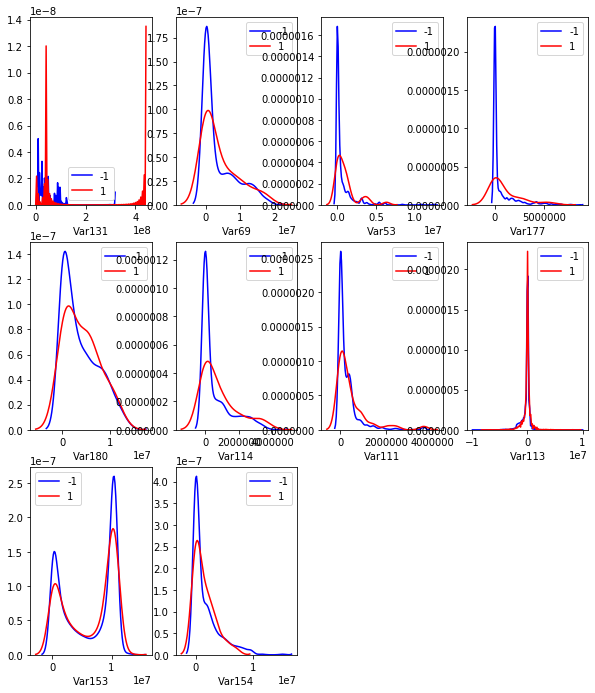

In [28]:
pyplot.figure(figsize(10, 20))
plot_number = 0
for column in features:
    plot_number += 1
    pyplot.subplot(5, 4, plot_number)
    colors = {-1: 'b', 1: 'r'}
    for i in [-1, 1]:
        sns.distplot(num[num['labels'] == i][column], color=colors[i], hist=False, label = i)
        

C:\Users\unikum\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\unikum\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


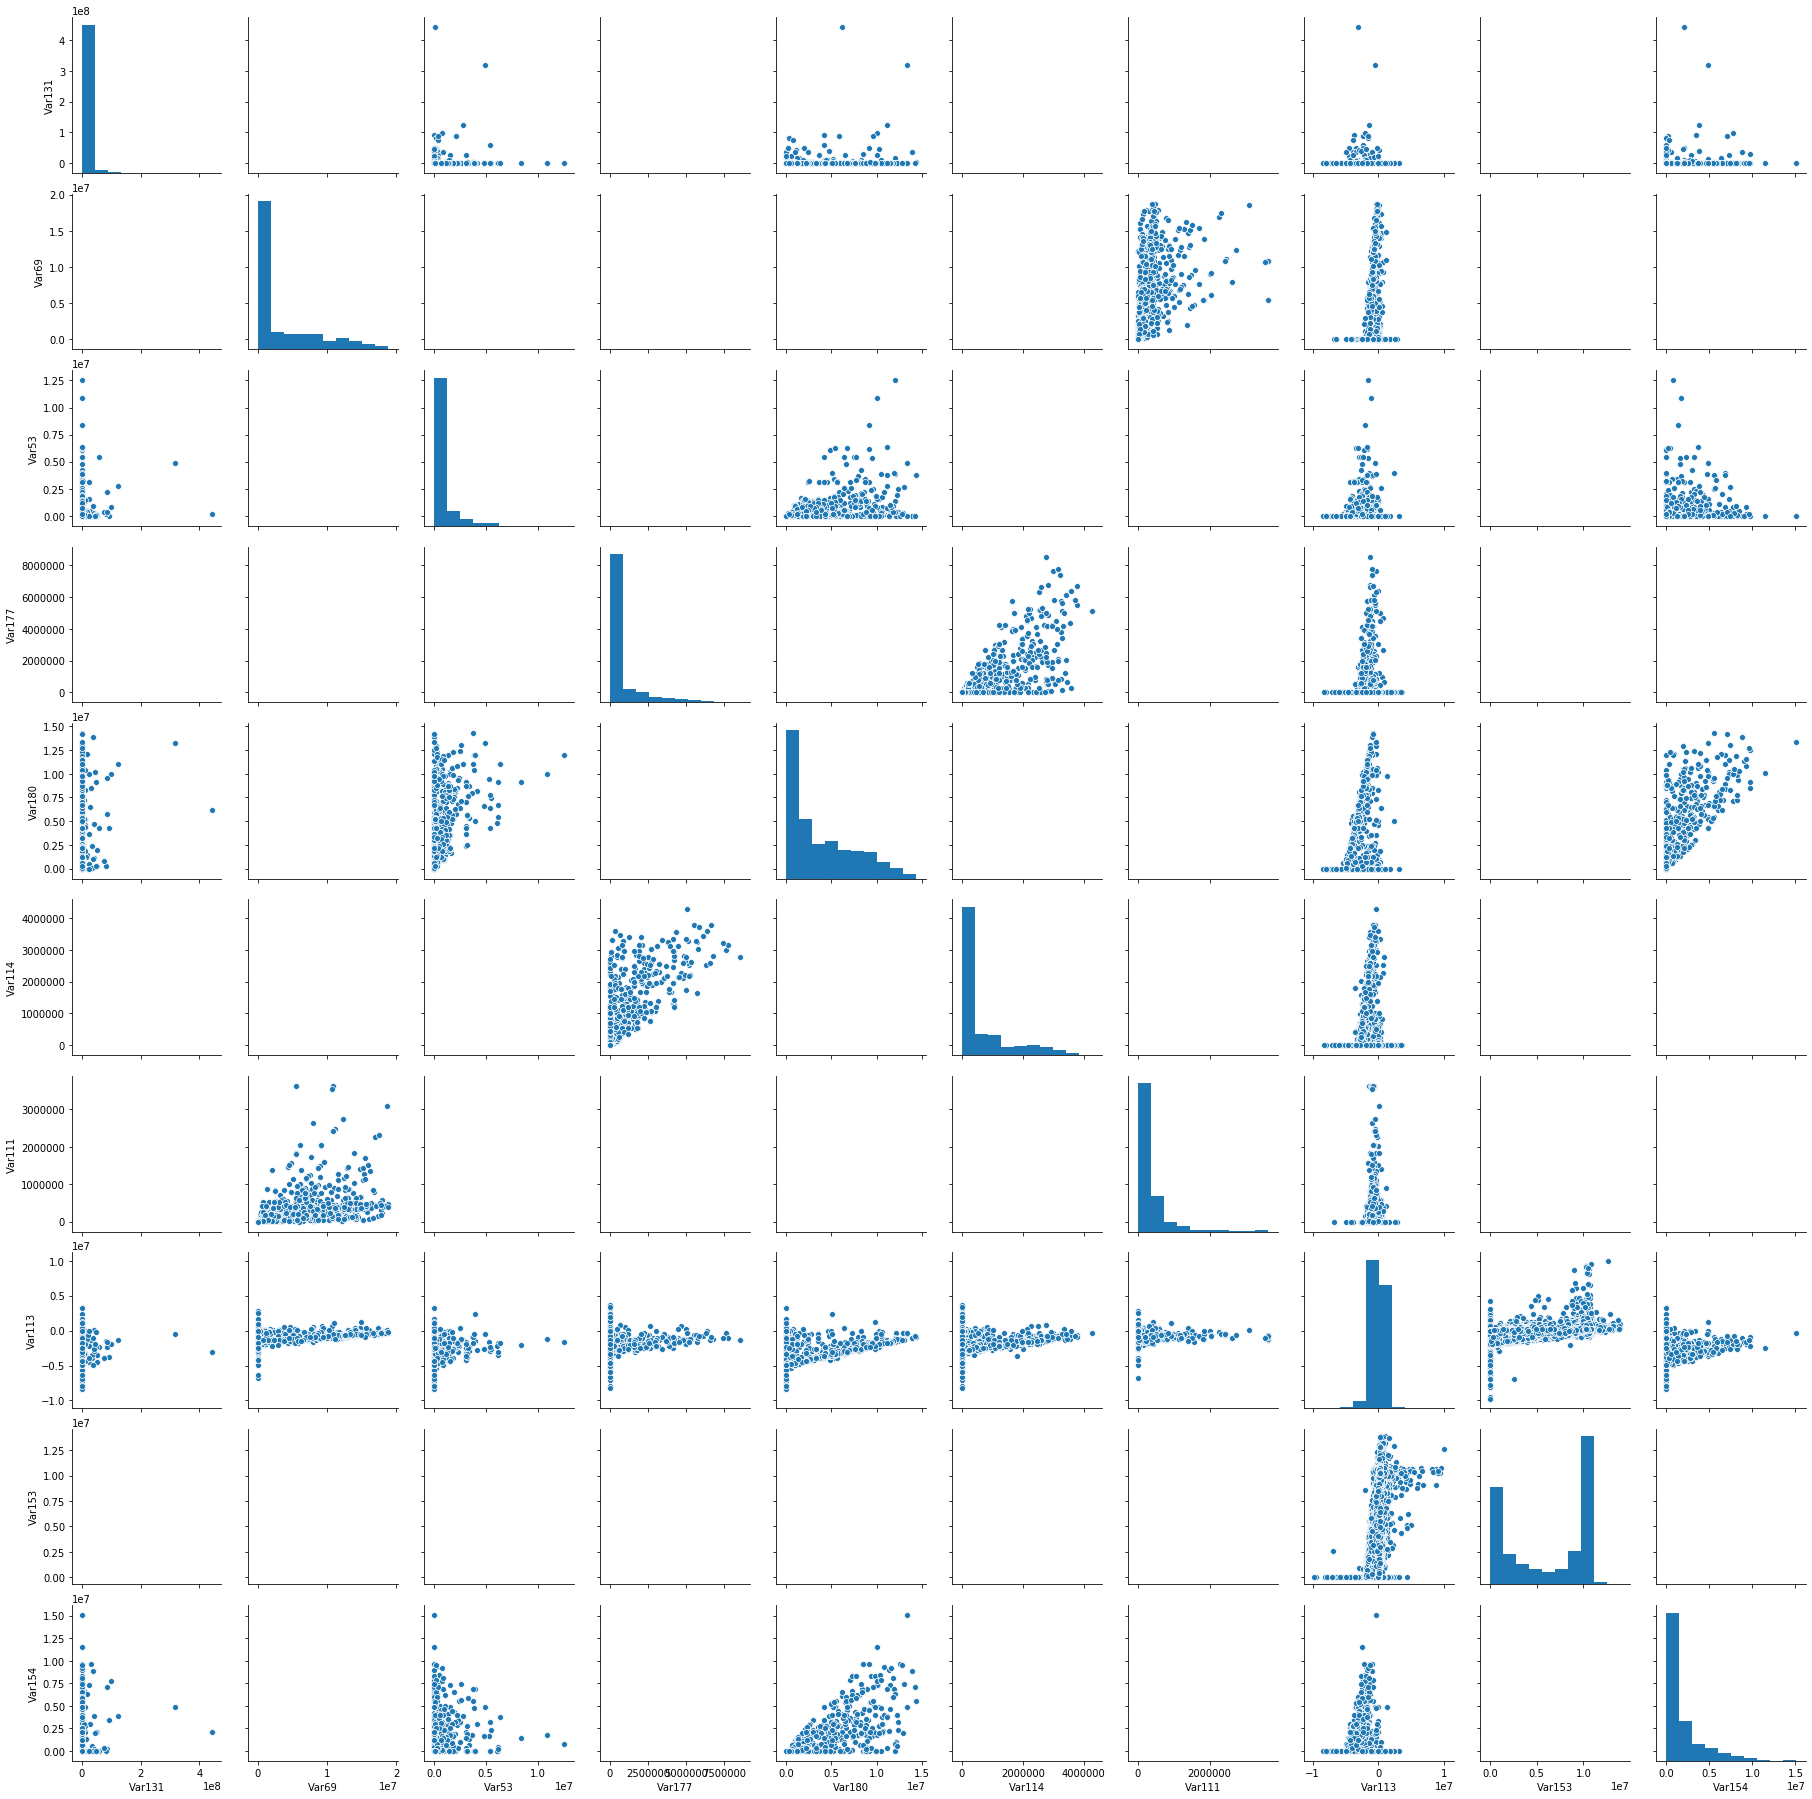

In [29]:
sns.pairplot(num[features])

5\. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

удалими null признаки / может попасть в рандом 

In [30]:
cor_num[cor_num.isnull()].index

Index(['Var8', 'Var15', 'Var20', 'Var31', 'Var32', 'Var39', 'Var42', 'Var48',
       'Var52', 'Var55', 'Var79', 'Var141', 'Var167', 'Var169', 'Var175',
       'Var185'],
      dtype='object')

In [31]:
cor_num.drop(cor_num[cor_num.isnull()].index)

Var1          1.670494
Var2         -0.005181
Var3       -167.782993
Var4          0.016095
Var5     -66949.866756
              ...     
Var186       -0.458211
Var187        2.679840
Var188       54.594774
Var189      -40.199637
Var190    -5216.922538
Length: 174, dtype: float64

In [32]:
num_after_del = num.drop(cor_num[cor_num.isnull()].index , axis='columns')

In [33]:
features_random = np.array(cor_num.drop(cor_num[cor_num.isnull()].index)[np.random.randint(1, 174, size = 10)].index)

C:\Users\unikum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\unikum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


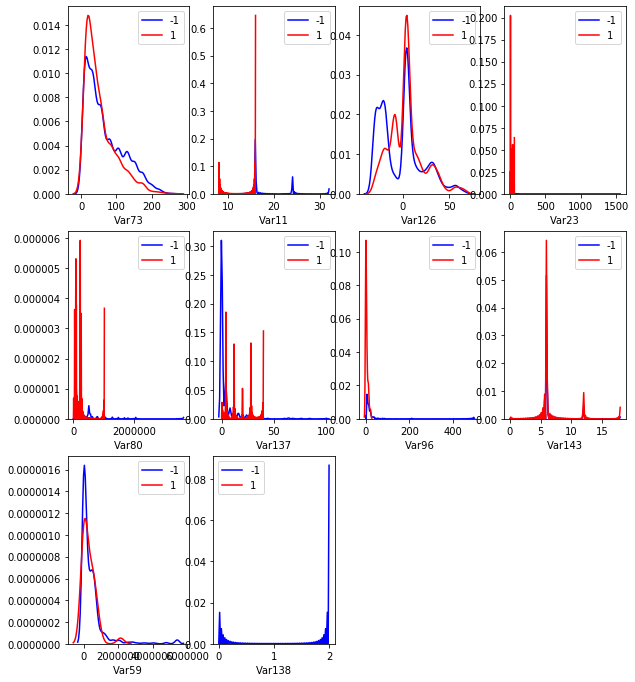

In [34]:
pyplot.figure(figsize(10, 20))
plot_number = 0
for column in features_random:
    plot_number += 1
    pyplot.subplot(5, 4, plot_number)
    colors = {-1: 'b', 1: 'r'}
    for i in [-1, 1]:
        sns.distplot(num[num['labels'] == i][column], color=colors[i], hist=False, label = i)

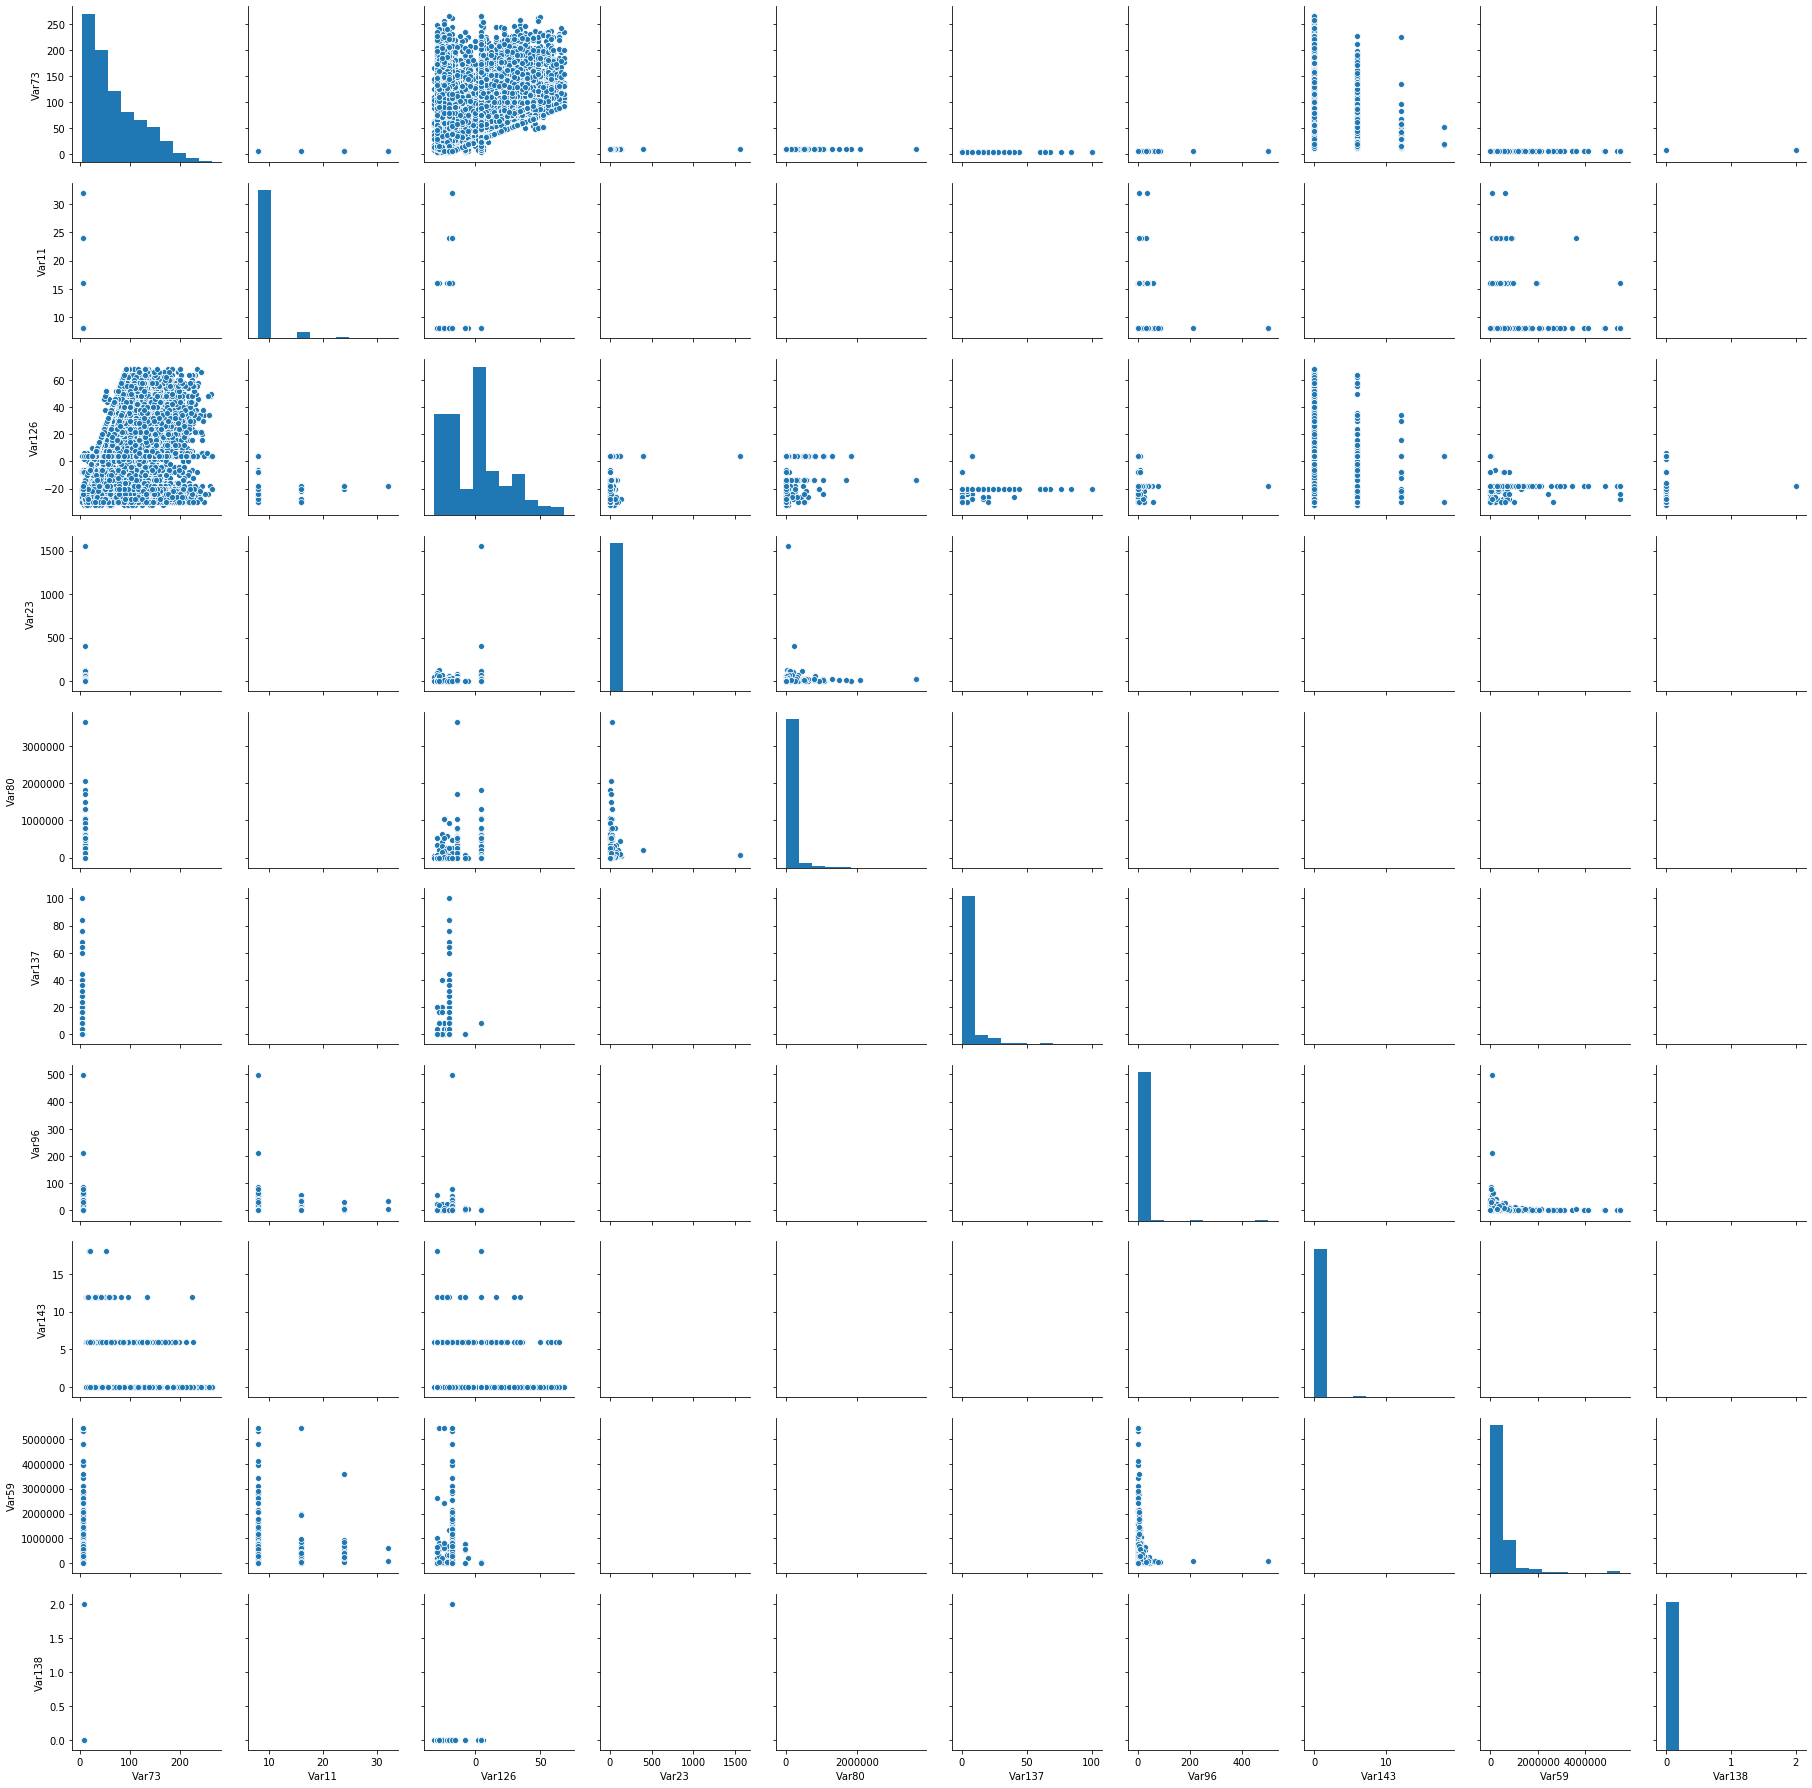

In [35]:
sns.pairplot(num, vars=features_random)

6\. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

In [36]:
features_low=np.array(cor_num.abs().sort_values(ascending=True)[:10].index)

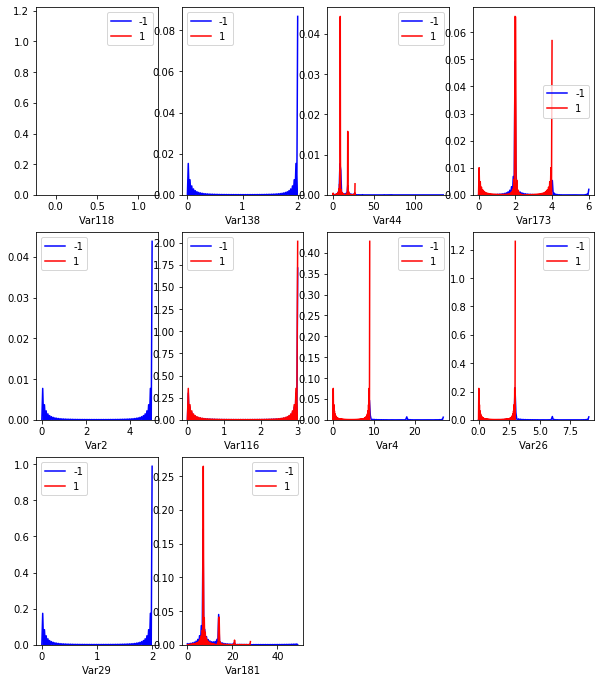

In [37]:
pyplot.figure(figsize(10, 20))
plot_number = 0
for column in features_low:
    plot_number += 1
    pyplot.subplot(5, 4, plot_number)
    colors = {-1: 'b', 1: 'r'}
    for i in [-1, 1]:
        sns.distplot(num[num['labels'] == i][column], color=colors[i], hist=False, label = i)

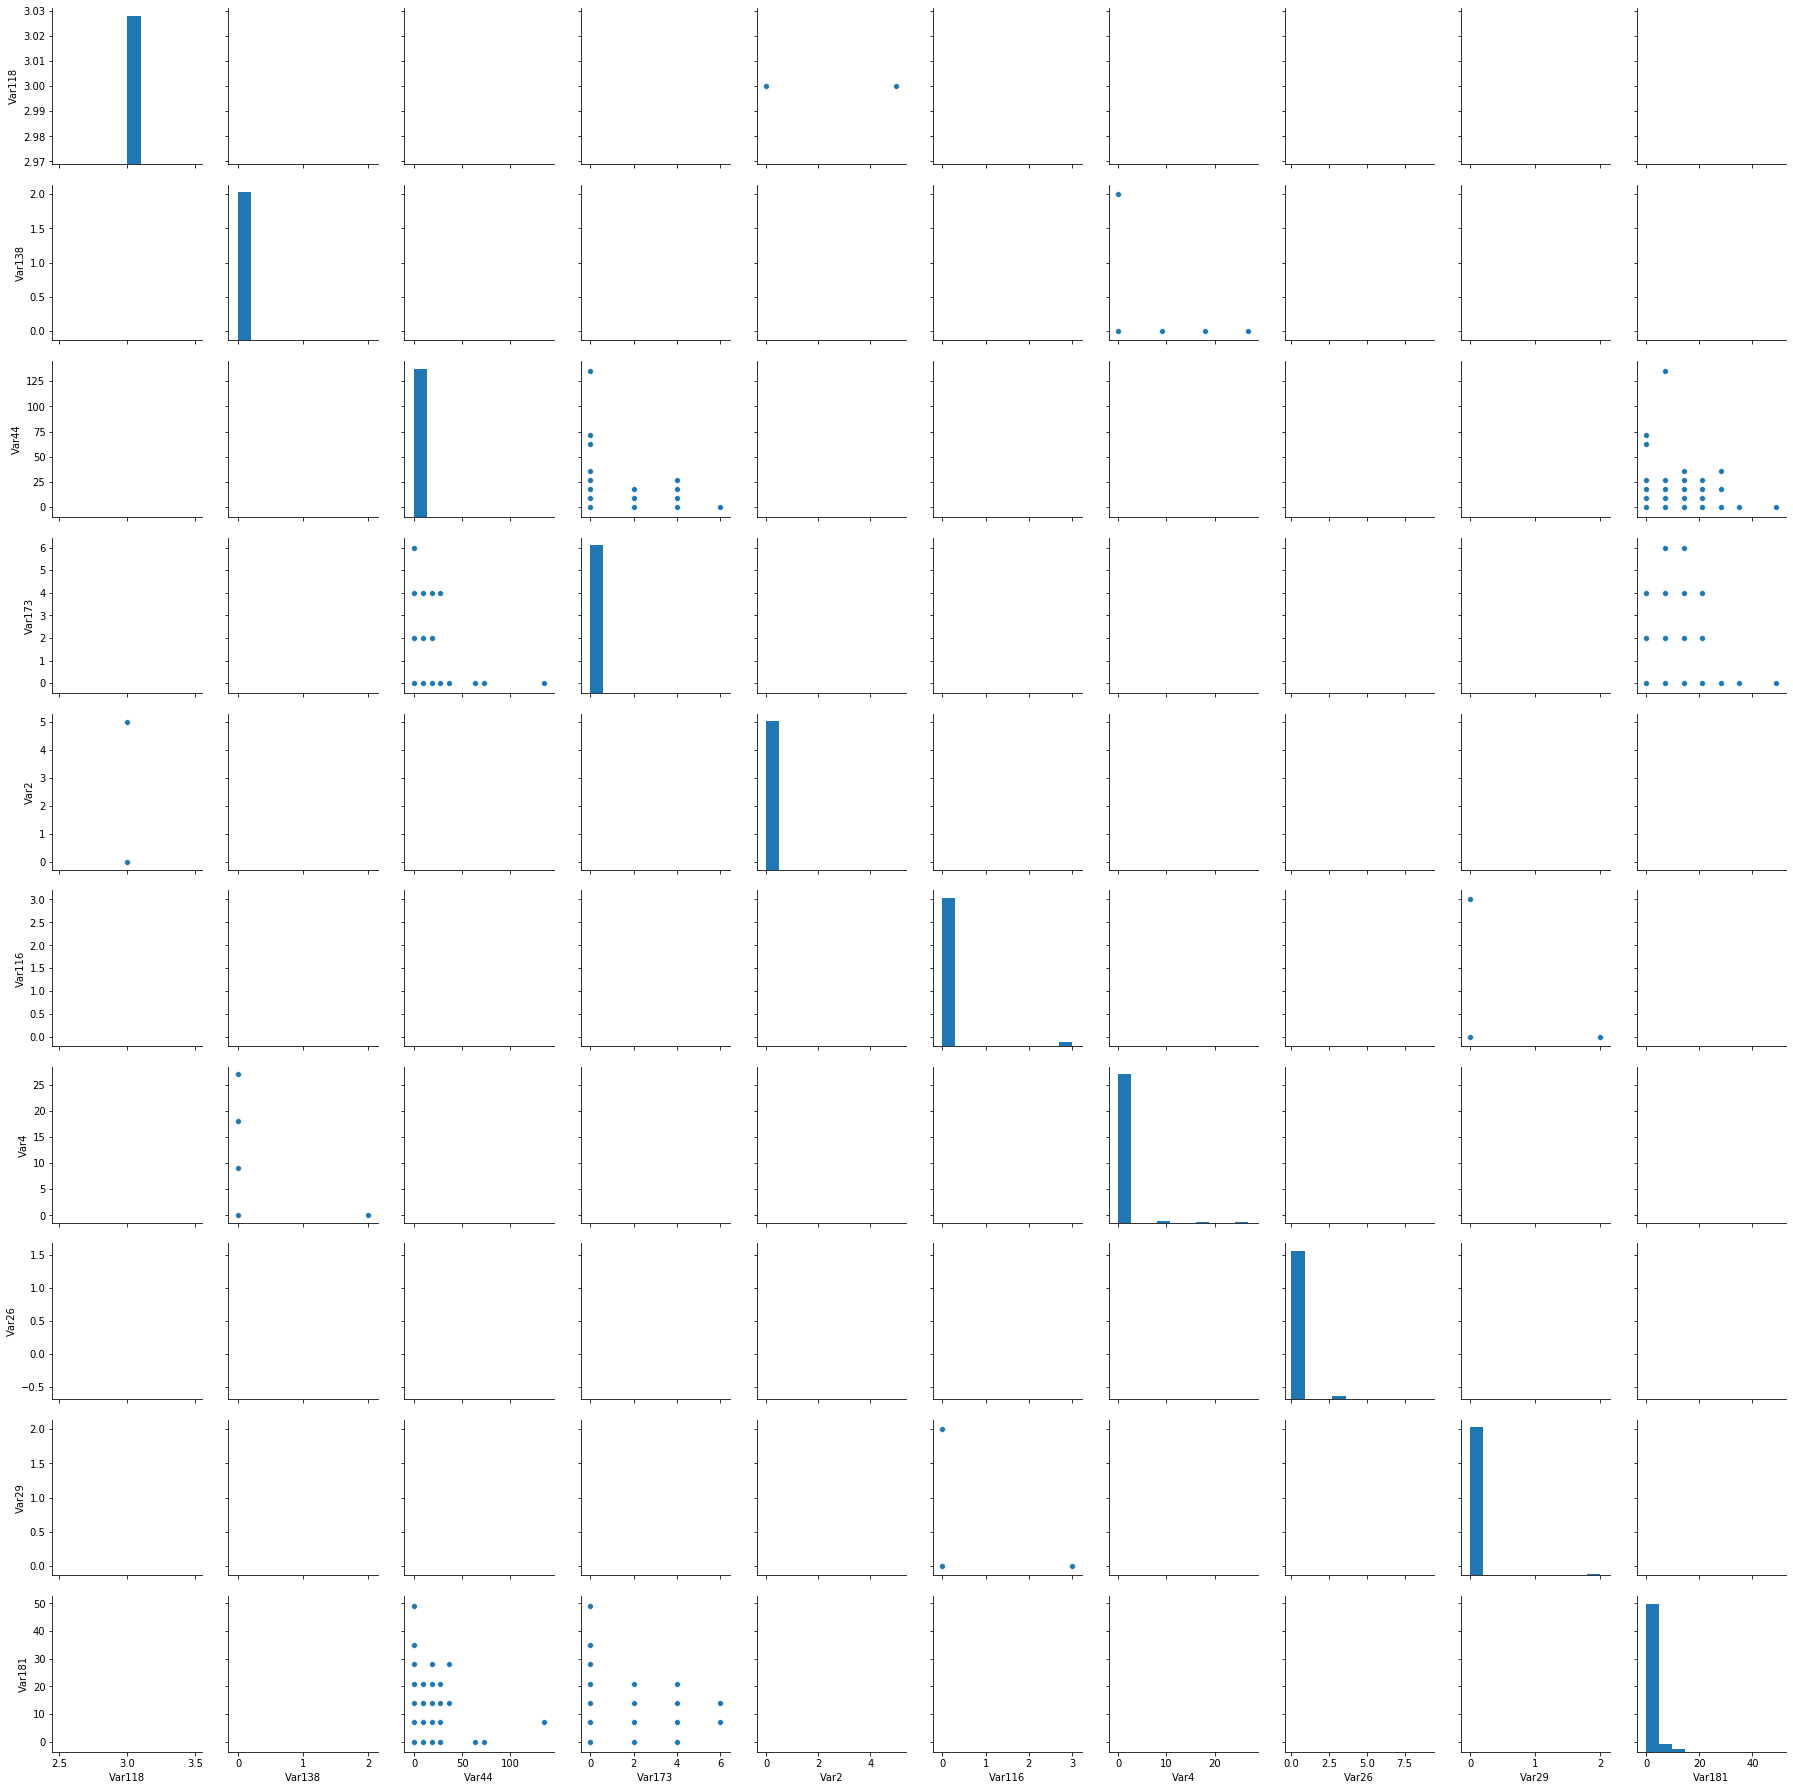

In [38]:
sns.pairplot(num[features_low])

7\. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

пропустим полностью null -ые признаки

In [39]:
cat.columns

Index(['Var191', 'Var192', 'Var193', 'Var194', 'Var195', 'Var196', 'Var197',
       'Var198', 'Var199', 'Var200', 'Var201', 'Var202', 'Var203', 'Var204',
       'Var205', 'Var206', 'Var207', 'Var208', 'Var209', 'Var210', 'Var211',
       'Var212', 'Var213', 'Var214', 'Var215', 'Var216', 'Var217', 'Var218',
       'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var224', 'Var225',
       'Var226', 'Var227', 'Var228', 'Var229', 'Var230', 'labels'],
      dtype='object')

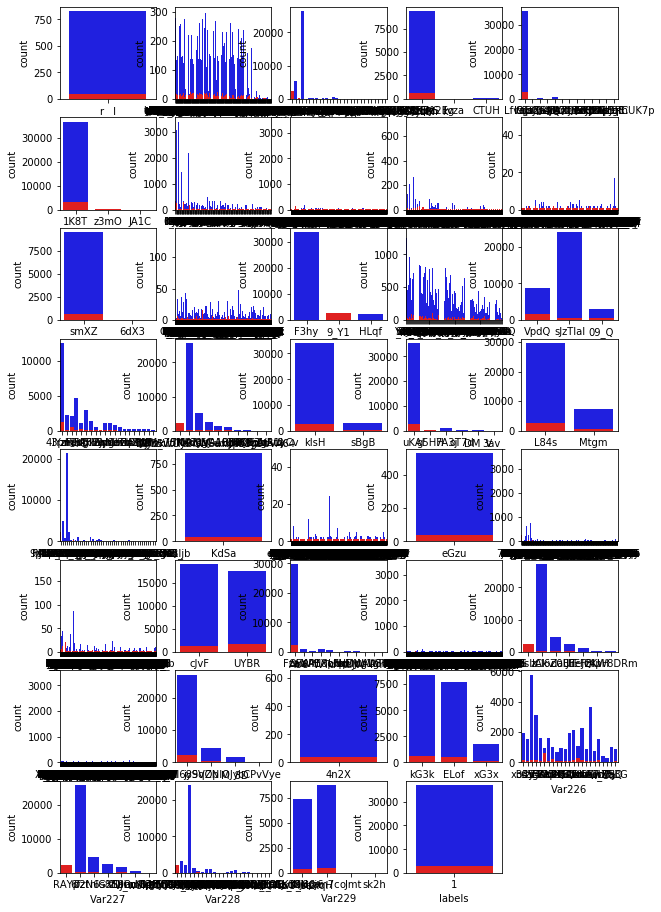

In [40]:
pyplot.figure(figsize(10, 20))
plot_number = 0
for column in cat.columns:
    if cat[column].isnull().sum() == cat.shape[0]:
        continue
    else:
        plot_number += 1
        pyplot.subplot(10, 5, plot_number)
        colors = {-1: 'b', 1: 'r'}
        for i in [-1, 1]:
            sns.countplot(cat[cat['labels'] == i][column], color=colors[i], label = i)

8\. Проанализируйте полученные результаты:
* Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?
* На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?
* Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?
* Как вы думаете, окажется ли отбор признаков полезным для построения модели?

    1. Данные сильно разреженны. очень много NaNов ( более 95% в признаке). Среди коррелирующих признаков видна разница в плотоности относительно целевого признака , например Var53. Есть вещественные признаки с 3 - 4 значениями, например Var173
    2. Окажут те признаки, в которых значений (не NaN) больше 80%. До проверки на пропуски важными признаками являются Var131    Var69. Среди категориальных - Var199
    3. Те переменные, в которых больше 95% Nanов. Требуется дополнительно проверить. Но уже сейчас можно признаки Var8, Var15, Var20 (100% Nan) т.д назвать шумовыми - их следовало бы удалить сразу
    4. ДА. в данных полно шума. Шумовые признаки нужно удалить. Nanы заполнить. 


Начнем с простого, но важного шага. Отделите небольшую выборку от существующих данных. Назовем её hold-out dataset. Эта выборка нужна для контроля качества решения: она не должна использоваться вплоть до контроля качества решения. Наличие такой выборки поможет убедиться, что в процессе моделирования не было допущено ошибок, не произошло переобучение. В качестве ответа загрузите полученный файл (или файлы, если вы работаете а данными и метками как с 2мя файлами)

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=123)

In [43]:
pd.value_counts(Y.label)[1]/pd.value_counts(Y.label)[-1]

0.08038029386343994

In [44]:
pd.value_counts(y_test.label)[1]/pd.value_counts(y_test.label)[-1]

0.08695652173913043

In [45]:
X_test['labels']= y_test

C:\Users\unikum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
X_test.to_csv("Hold-out Dataset.csv",index = False)

Подумайте и предложите несколько способов (не менее 3х) обработки категориальных признаков, для того, чтобы их можно было использовать при построении модели

Onehotencoder / get_dummies / Replace Values with a map()

Подумайте, с помощью какой метрики качества лучше всего оценивать качество будущей модели, какой будет ключевая метрика качества? Поясните свой выбор.

бинаркая классификация  , поэтому AUC-ROC.

Какие вспомогательные метрики качества имеет смысл считать, чтобы более полно оценить качество модели, понять, где её слабые стороны и что нужно улучшать?

Precision, Recall, F-мера.

Accuracy - бесполенезен в задачах с несбалансированными классами

Подберите оптимальную стратегию проведения кросс-валидации: решите, на сколько фолдов вы будете делить выборку? Выберите тип разбиения данных (k-fold, stratified k-fold, shuffle split, leave one out). Поясните ваш выбор.

5/6/7 - достаточно. stratified k-fold - т.к. классы не сбалансирвоаны  - 93/7.

**Обучите 3 разные baseline-модели на полученных наборах данных и оцените их качество**. 

На прошлой неделе вы выбрали методику оценки качества моделей на основе кросс-валидации, а также основную и вспомогательные метрики. Оцените с их помощью получившуюся модель. Обратите внимание, что под разными моделями понимаются именно разные алгоритмы классификации. Например, 2 модели, реализующие метод k ближайших соседей с разными k, будут считаться одним baseline-решением (хотя и с разными параметрами). Напоминаем, что отложенная выборка (hold-out dataset) не должна использоваться для построения и оценки baseline-моделей!

Найдем все наны, нормализуем и преобразуем данные.

Удалим данные с пропусками более 95% а так же заменим в кат признакаках Наны на NO

In [47]:
40000*0.05

2000.0

In [48]:
numer = X.iloc[:,0:190]
categ = X.iloc[:,190:]

In [49]:
numer.dropna(axis=1, thresh=2000, subset=None, inplace=True)
categ.dropna(axis=1, thresh=2000, subset=None, inplace=True)

In [50]:
numer.describe(include=['float64','int64']).min() == numer.describe(include=['float64','int64']).max()

Var6      False
Var7      False
Var13     False
Var21     False
Var22     False
Var24     False
Var25     False
Var28     False
Var35     False
Var38     False
Var44     False
Var51     False
Var57     False
Var65     False
Var72     False
Var73     False
Var74     False
Var76     False
Var78     False
Var81     False
Var83     False
Var85     False
Var94     False
Var109    False
Var112    False
Var113    False
Var119    False
Var123    False
Var125    False
Var126    False
Var132    False
Var133    False
Var134    False
Var140    False
Var143    False
Var144    False
Var149    False
Var153    False
Var160    False
Var163    False
Var173    False
Var181    False
Var189    False
dtype: bool

In [51]:
numer.fillna(numer.mean(),inplace=True)
categ.fillna('NO', inplace=True)

In [52]:
from sklearn import preprocessing

In [53]:
normed = preprocessing.scale(numer)

**проверим на константу и закодируем**

In [54]:
bad = []
for i in range(categ.shape[1]):
    if len(set(categ.iloc[:,i])) == 1:
        bad.append(categ.columns[i])
if len(bad)==0:
    print('Good') 

Good


In [55]:
def labelEncoder(data):
    data.apply(str)
    le = preprocessing.LabelEncoder()
    for m in range(data.shape[1]):
        le.fit(data.iloc[:,m])
        data.iloc[:,m] = le.transform(data.iloc[:,m])        
    return data

In [56]:
labelEncoder(categ)

,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
0,159,5,1,22,0,0,1961,1235,5258,1,...,11,2855,0,3696,0,1,14,0,29,0
1,169,0,1,22,0,127,743,3521,3019,1,...,11,2864,4,347,0,0,22,2,2,2
2,114,17,1,22,0,111,2693,3463,5258,1,...,11,328,6,2498,0,1,7,3,25,2
3,329,25,1,22,0,2,3619,1542,5258,1,...,11,3834,4,2602,0,1,22,2,8,0
4,38,25,1,22,0,206,3005,2496,5258,1,...,11,1653,4,1375,0,1,12,2,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,130,25,2,22,0,70,3343,910,4331,2,...,11,1907,4,505,0,2,7,2,8,2
39996,317,25,1,22,0,175,2084,3775,5258,1,...,11,361,4,2062,0,1,12,2,8,0
39997,87,25,1,22,0,17,929,1515,9417,1,...,11,752,4,3305,0,0,12,2,8,1
39998,241,25,1,22,0,17,2751,2825,5258,1,...,11,1787,4,2037,0,1,20,2,8,0


In [57]:
X_new = pd.concat([numer,categ],axis=1)

In [58]:
print(X_new.shape,numer.shape,categ.shape)

(40000, 77) (40000, 43) (40000, 34)


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_new,Y, test_size=0.1, random_state=123)

In [60]:
X_test['labels']= y_test

X_test.to_csv("Hold-out Dataset.csv",index = False)

C:\Users\unikum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Baseline**

In [61]:
from sklearn import ensemble, linear_model,model_selection, metrics
import warnings
warnings.filterwarnings('ignore')

In [62]:
score = ['roc_auc', 'precision', 'recall', 'f1_weighted']

In [90]:
def result(estimator, X, Y, score=score):
    skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    for i in score:
        res = model_selection.cross_val_score(estimator, X, Y, scoring=i, cv = skf)
        print("Scores for metric %s:" % i)
        print(res)
        print(res.mean())
    print('==============================================')

In [64]:
ridge_classifier = linear_model.RidgeClassifier(random_state = 122)

In [65]:
result (ridge_classifier, X_train, y_train)

Scores for metric roc_auc:
[0.65531866 0.66319218 0.66890176 0.69263865 0.65724242]
Scores for metric precision:
[0. 0. 0. 0. 0.]
Scores for metric recall:
[0. 0. 0. 0. 0.]
Scores for metric f1_weighted:
[0.89078683 0.89078683 0.89078683 0.89078683 0.89058392]


In [66]:
RandomForestClassifier = ensemble.RandomForestClassifier(random_state = 122)

In [67]:
result (RandomForestClassifier, X_train, y_train)

Scores for metric roc_auc:
[0.6586     0.68519959 0.69378401 0.68628522 0.69015746]
Scores for metric precision:
[0.  0.5 0.  0.  1. ]
Scores for metric recall:
[0. 0. 0. 0. 0.]
Scores for metric f1_weighted:
[0.89071748 0.89078683 0.89071748 0.89078683 0.8909254 ]


In [68]:
GradientBoostingClassifier = ensemble.GradientBoostingClassifier(random_state = 122)

In [91]:
result (GradientBoostingClassifier, X_train, y_train)

Scores for metric roc_auc:
[0.74467552 0.74072803 0.7249618  0.73046482 0.7228808 ]
0.7327421944992557
Scores for metric precision:
[0.36363636 0.64705882 0.33333333 0.66666667 0.56      ]
0.5141390374331551
Scores for metric recall:
[0.02259887 0.02636535 0.01318267 0.01129944 0.01503759]
0.017696784333715642
Scores for metric f1_weighted:
[0.8944413  0.89187913 0.89264549 0.89300998 0.8938844 ]
0.8931720592437973


In [83]:
import xgboost as xgb

In [88]:
estimator = xgb.XGBClassifier()

In [92]:
result (estimator, X_train, y_train)

Scores for metric roc_auc:
[0.74265575 0.73238025 0.74666324 0.72840156 0.72770789]
0.7355617373854735
Scores for metric precision:
[0.6        0.8        0.5        0.66666667 0.4       ]
0.5933333333333333
Scores for metric recall:
[0.0094162  0.01129944 0.00753296 0.01129944 0.0056391 ]
0.009037424068646192
Scores for metric f1_weighted:
[0.89105845 0.892748   0.89241211 0.89226828 0.89160528]
0.8920184218164314


**xgb оказался чуть лучше по рок ауку. но хуже по реколу. так как рекол в задачах с ошибкой 2 рода важнее. заюзаю xgb из скайлерна**

**обработаем тестовую выборку с трейном повторно**

In [103]:
dtest = pd.read_csv('orange_small_churn_test_data.csv')
dtrain = pd.read_csv('orange_small_churn_data.txt')

In [104]:
dtest_num = dtest.iloc[:, 1:191]
dtest_cat = dtest.iloc[:, 191:]

In [105]:
dtest_num.fillna(numer.mean(),inplace=True)
dtest_cat.fillna('NO', inplace=True)

In [106]:
def labelEncoder(data):
    data.apply(str)
    le = preprocessing.LabelEncoder()
    for m in range(data.shape[1]):
        le.fit(data.iloc[:,m])
        data.iloc[:,m] = le.transform(data.iloc[:,m])        
    return data

In [107]:
labelEncoder(dtest_cat)

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,0,132,0,1,16,0,2,825,1672,1394,...,6,302,4,1,0,22,1,18,0,0
1,0,177,19,1,16,0,2,229,881,1758,...,4,577,0,1,1,22,2,8,0,0
2,0,44,19,2,16,0,32,1320,1058,1541,...,4,173,0,1,2,17,2,8,2,0
3,0,152,19,2,16,0,14,255,535,2583,...,4,149,4,1,2,17,2,8,1,0
4,0,223,19,1,16,0,143,1390,190,1758,...,4,694,0,1,1,4,2,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,221,19,1,16,0,51,1486,78,3281,...,6,799,0,1,0,22,3,11,1,0
9996,0,100,0,1,16,0,57,402,135,677,...,4,1809,0,1,0,12,2,2,2,0
9997,0,45,0,1,16,0,92,1255,1036,829,...,4,6,1,1,0,11,2,2,1,0
9998,0,109,0,1,16,0,89,1523,460,1758,...,4,876,0,1,1,19,2,2,0,0


In [108]:
dtest_new = pd.concat([dtest_num,dtest_cat],axis=1)

In [109]:
print(dtest_new.shape,dtest_num.shape,dtest_cat.shape)

(10000, 230) (10000, 190) (10000, 40)


In [110]:
dtest_new1 = dtest_new [X_train.columns]

**Baseline / GradientBoostingClassifier/ ограничем число деревьев 30. что б не перебучился и глубину в 3, что не падало кач-во **

In [93]:
estimator.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [115]:
dtest['y'] = estimator.predict_proba(dtest_new1)[:,1]

In [123]:
answer = pd.DataFrame({'ID':range(0, dtest.shape[0]), 'result':dtest['y']})

In [125]:
answer.to_csv('kaggle_churn_prediction.csv', index = False)

In [126]:
answer.head()

,ID,result
0,0,0.089432
1,1,0.099931
2,2,0.024113
3,3,0.081814
4,4,0.025039


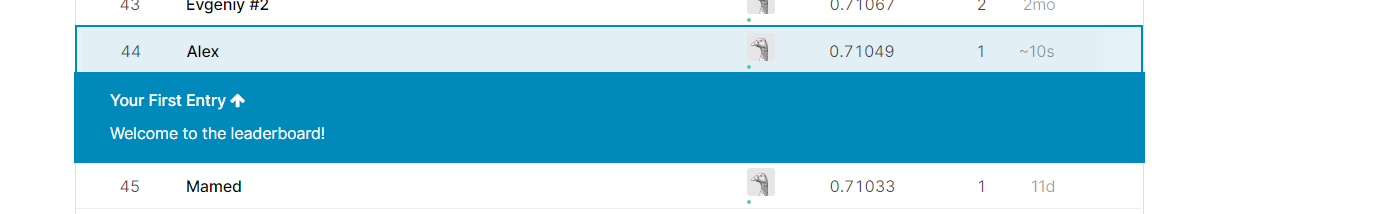

In [127]:
from IPython.display import Image
Image("kaggle1.PNG")